The goal of this file is to load, analyze, and visualize flight trajectory data.

The script performs several key actions:
- Loads flight data from individual Parquet files (prc770847190.parquet) and metadata files (flightlist_train.parquet, apt.parquet).
- Analyzes the data by:
    - Identifying a flight's origin and destination airports.
    - Grouping flights that share the same origin-destination route.
    - Building a dictionary of all unique routes and their corresponding flights.
- Visualizes the data by:
    - Plotting the latitude/longitude path of individual flights.
    - Plotting these paths on a map using contextily.
    - Plotting time-series data for features like altitude, groundspeed, track, and vertical_rate.

Thibault lootvoet + copilot

In [10]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter


def load_parquet(file_path: str) -> pd.DataFrame:
    """
    Load a Parquet file into a pandas DataFrame.

    Parameters:
    file_path (str): The path to the Parquet file.

    Returns:
    pd.DataFrame: The loaded DataFrame.
    """
    try:
        df = pd.read_parquet(file_path)
        return df
    except Exception as e:
        print(f"An error occurred while loading the Parquet file: {e}")

Index(['timestamp', 'flight_id', 'typecode', 'latitude', 'longitude',
       'altitude', 'groundspeed', 'track', 'vertical_rate', 'mach', 'TAS',
       'CAS', 'source'],
      dtype='object')
Origin ICAO: ZSPD, Destination ICAO: LFML
Origin Info:
      icao  longitude  latitude  elevation
8668  ZSPD    121.805   31.1434       13.0, Destination Info:
      icao  longitude   latitude  elevation
4376  LFML     5.2125  43.438088       74.0


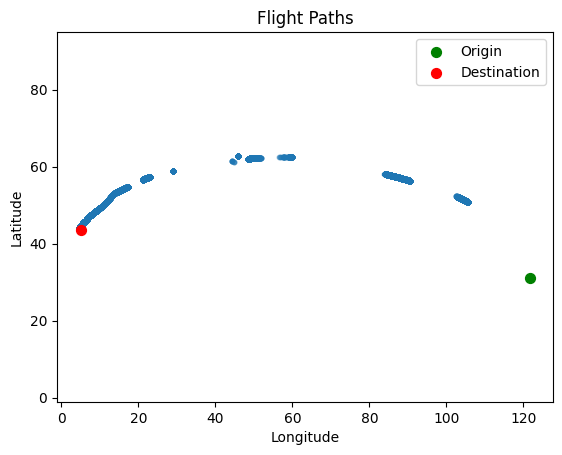

In [2]:
# set path to the mother folder containing the data files
base_dir = "../.."

df = load_parquet(f"{base_dir}/data/flights_train/prc770847190.parquet")

print(df.columns)

# look for this flight_id in flightlist_train.parquet
flightlist_df = load_parquet(f"{base_dir}/data/flightlist_train.parquet")
matching_flights = flightlist_df[
    flightlist_df["flight_id"] == df["flight_id"].values[0]
]
origin_icao = matching_flights["origin_icao"].values[0]
destination_icao = matching_flights["destination_icao"].values[0]
print(f"Origin ICAO: {origin_icao}, Destination ICAO: {destination_icao}")

# look for the origin and destination in apt.parquet
apt_df = load_parquet(f"{base_dir}/data/apt.parquet")
origin_info = apt_df[apt_df["icao"] == origin_icao]
destination_info = apt_df[apt_df["icao"] == destination_icao]
print(f"Origin Info:\n{origin_info}, Destination Info:\n{destination_info}")

# plot all "latitude", "longitude" pairs
plt.scatter(df["longitude"], df["latitude"], alpha=0.5, s=10)
plt.scatter(
    origin_info["longitude"],
    origin_info["latitude"],
    color="green",
    label="Origin",
    s=50,
)
plt.scatter(
    destination_info["longitude"],
    destination_info["latitude"],
    color="red",
    label="Destination",
    s=50,
)
plt.legend()
plt.title("Flight Paths")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.show()

In [3]:
# among all the files in data/flights_train, identify the ones that have a flight_id that is "prc801785556"
# load the files in the order they appear in


all_files = os.listdir(f"{base_dir}/data/flights_train")
list_of_similar_flights = []
for i in range(5879):
    file_path = os.path.join(f"{base_dir}/data/flights_train", all_files[i])
    temp_df = load_parquet(file_path)
    # check for flights that have the same origin and destination as the current df
    try:
        temp_matching_flights = flightlist_df[
            flightlist_df["flight_id"] == temp_df["flight_id"].values[0]
        ]
    except Exception:
        continue
    # temp_matching_flights = flightlist_df[flightlist_df["flight_id"] == temp_df["flight_id"].values[0]]
    if temp_matching_flights.empty:
        continue
    temp_origin_icao = temp_matching_flights["origin_icao"].values[0]
    temp_destination_icao = temp_matching_flights["destination_icao"].values[0]
    if temp_origin_icao == origin_icao and temp_destination_icao == destination_icao:
        list_of_similar_flights.append(temp_df["flight_id"].values[0])

print(f"Similar flights with same origin and destination: {list_of_similar_flights}")

Similar flights with same origin and destination: ['prc773767427', 'prc783329855', 'prc778960130', 'prc770847190', 'prc799498970', 'prc779914176', 'prc772064689', 'prc784200860', 'prc776461657']


In [4]:
print(len(list_of_similar_flights))

9


In [5]:
# iterate over all files in data/flights_train and create a dictiionary with (origin_icao, destination_icao) as key and list of flight_ids as value
# do this in a smart way to avoid loading the same flightlist_train.parquet file multiple times
from tqdm import trange

flight_dict = {}
for i in trange(5879):
    file_path = os.path.join(f"{base_dir}/data/flights_train", all_files[i])
    temp_df = load_parquet(file_path)
    try:
        temp_matching_flights = flightlist_df[
            flightlist_df["flight_id"] == temp_df["flight_id"].values[0]
        ]
    except Exception:
        continue
    if temp_matching_flights.empty:
        continue
    temp_origin_icao = temp_matching_flights["origin_icao"].values[0]
    temp_destination_icao = temp_matching_flights["destination_icao"].values[0]
    key = (temp_origin_icao, temp_destination_icao)
    if key not in flight_dict:
        flight_dict[key] = []
    flight_dict[key].append(temp_df["flight_id"].values[0])

print(f"Flight dictionary keys: {list(flight_dict.keys())}")

100%|██████████| 5879/5879 [00:25<00:00, 230.65it/s]

Flight dictionary keys: [('ZSPD', 'YMML'), ('LFPG', 'SKBO'), ('RPLC', 'ZSYW'), ('MMGL', 'KIAH'), ('KBOS', 'KFLL'), ('KOAK', 'MMGL'), ('YSSY', 'ZSPD'), ('OMDB', 'EGPH'), ('LEMD', 'ZSPD'), ('ZSPD', 'YSSY'), ('YSSY', 'ZSHC'), ('SAEZ', 'LIRF'), ('MMMM', 'KSJC'), ('ZSPD', 'KDTW'), ('KMIA', 'SKBO'), ('KSFO', 'MSLP'), ('KIAH', 'MMGL'), ('KLAX', 'MMMM'), ('VGSY', 'OMDW'), ('KATL', 'RKSI'), ('MGGT', 'KLAX'), ('EHAM', 'TNCA'), ('KLAX', 'LIRF'), ('KIAD', 'MSLP'), ('ZBAA', 'EHAM'), ('TNCB', 'EHAM'), ('SKBO', 'KMCO'), ('MSLP', 'KIAD'), ('ZSPD', 'VMMC'), ('MSLP', 'KLAX'), ('KBOS', 'KCHS'), ('MMQT', 'KORD'), ('CYUL', 'SKBO'), ('EFHK', 'EBBR'), ('KDTW', 'KMSP'), ('KSJC', 'MMZC'), ('KJFK', 'LLBG'), ('MNMG', 'KMIA'), ('KBOS', 'KBWI'), ('KBOS', 'KATL'), ('RCTP', 'YBBN'), ('KATL', 'KMCO'), ('KRSW', 'KBOS'), ('KBOS', 'KMCO'), ('MMOX', 'KLAX'), ('MMGL', 'KEWR'), ('KBOS', 'KMYR'), ('EDDP', 'KJFK'), ('MMGL', 'KSJC'), ('KJFK', 'SEGU'), ('KJFK', 'HECA'), ('KJFK', 'SKCL'), ('MMSD', 'KOAK'), ('LIPZ', 'ZSPD'), ('L

In [6]:
# print sum of values in flight_dict
total_flights = sum(len(v) for v in flight_dict.values())
print(f"Total number of flights in flight_dict: {total_flights}")

# print number of unique origin-destination pairs
print(f"Number of unique origin-destination pairs: {len(flight_dict)}")

# print number of icao codes in apt.parquet and compare with number of unique origin and destination icao codes in flightlist_train.parquet
apt_df = load_parquet(f"{base_dir}/data/apt.parquet")
unique_icao_codes_in_apt = set(apt_df["icao"].values)
print(f"Number of ICAO codes in apt.parquet: {len(unique_icao_codes_in_apt)}")
unique_origin_icao_codes = set(flightlist_df["origin_icao"].values)
unique_destination_icao_codes = set(flightlist_df["destination_icao"].values)
unique_icao_codes_in_flightlist = unique_origin_icao_codes.union(
    unique_destination_icao_codes
)
print(
    f"Number of unique ICAO codes in flightlist_train.parquet: {len(unique_icao_codes_in_flightlist)}"
)

Total number of flights in flight_dict: 5878
Number of unique origin-destination pairs: 843
Number of ICAO codes in apt.parquet: 8787
Number of unique ICAO codes in flightlist_train.parquet: 320


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


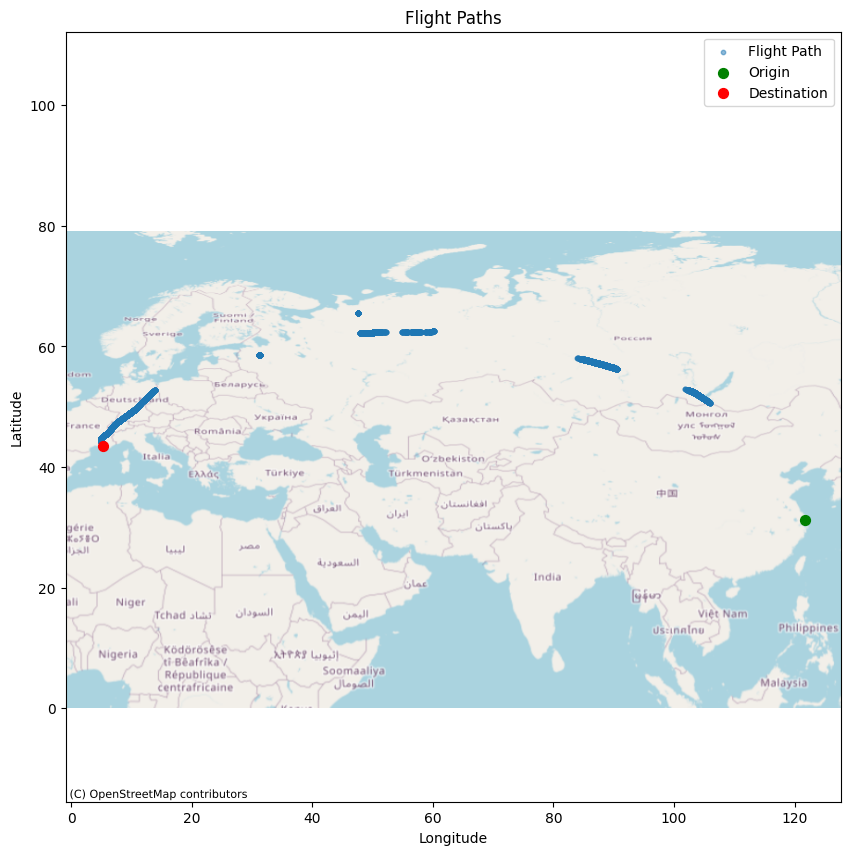

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


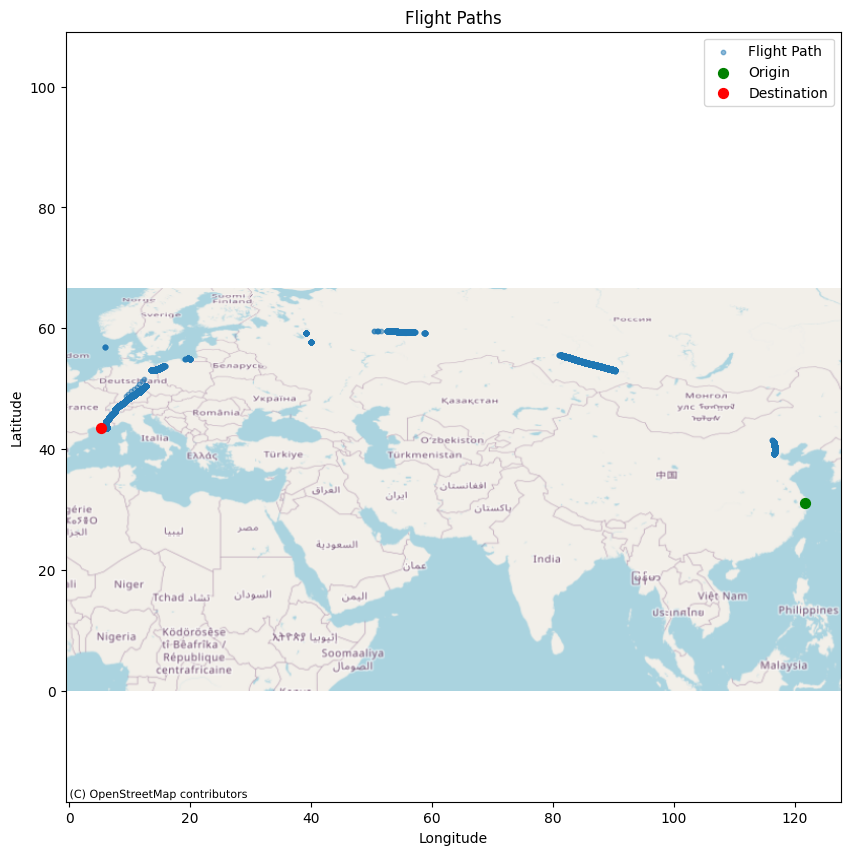

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


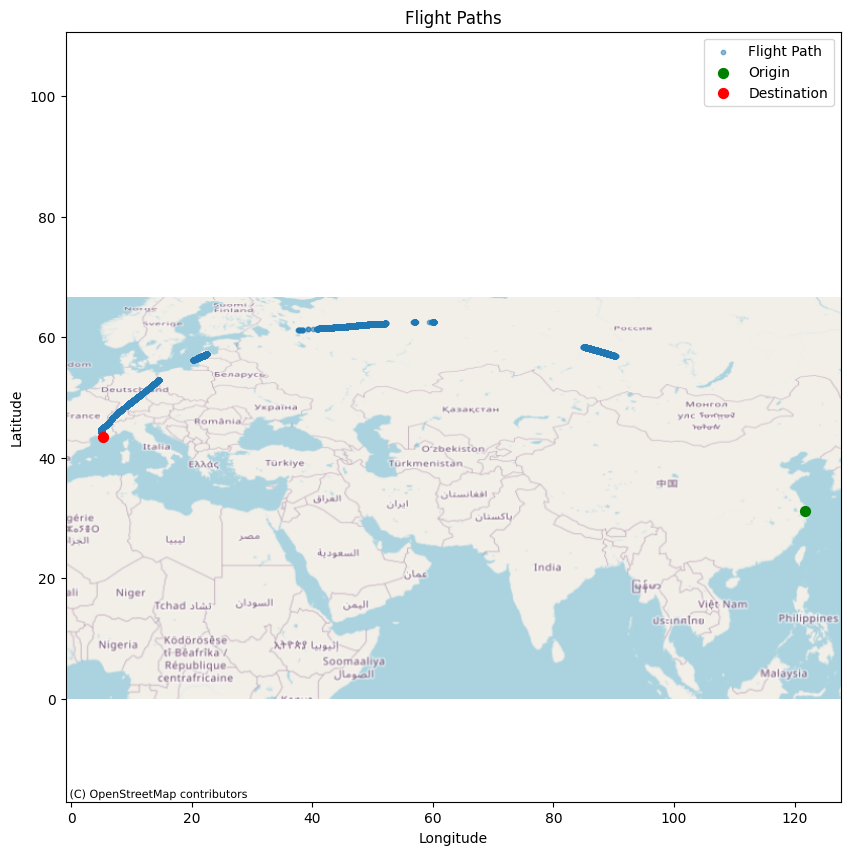

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


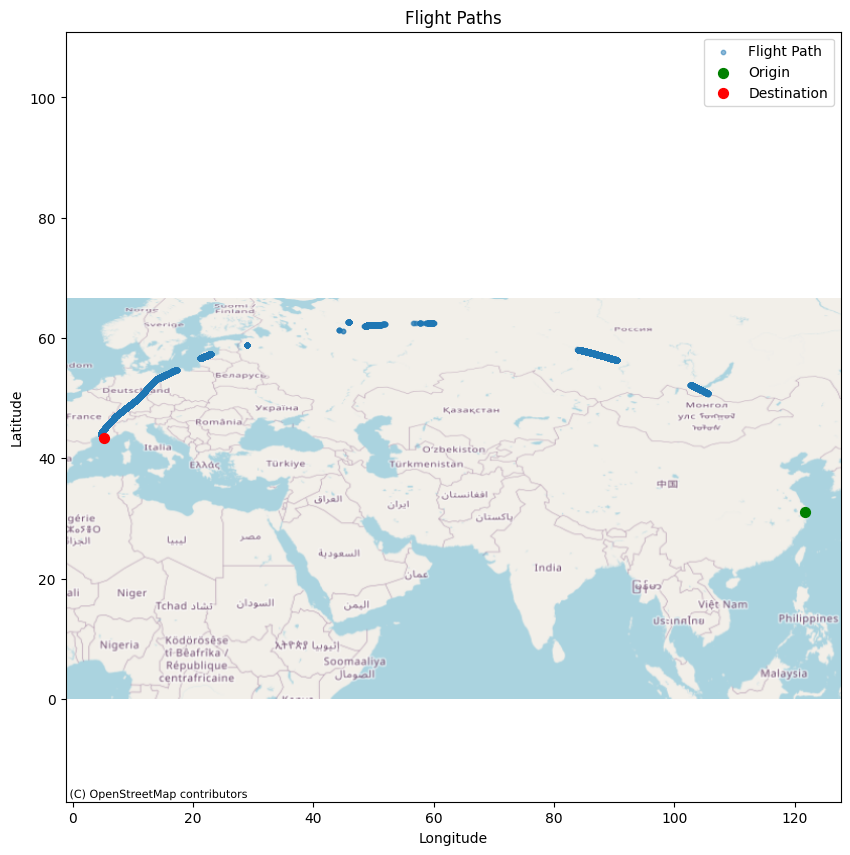

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


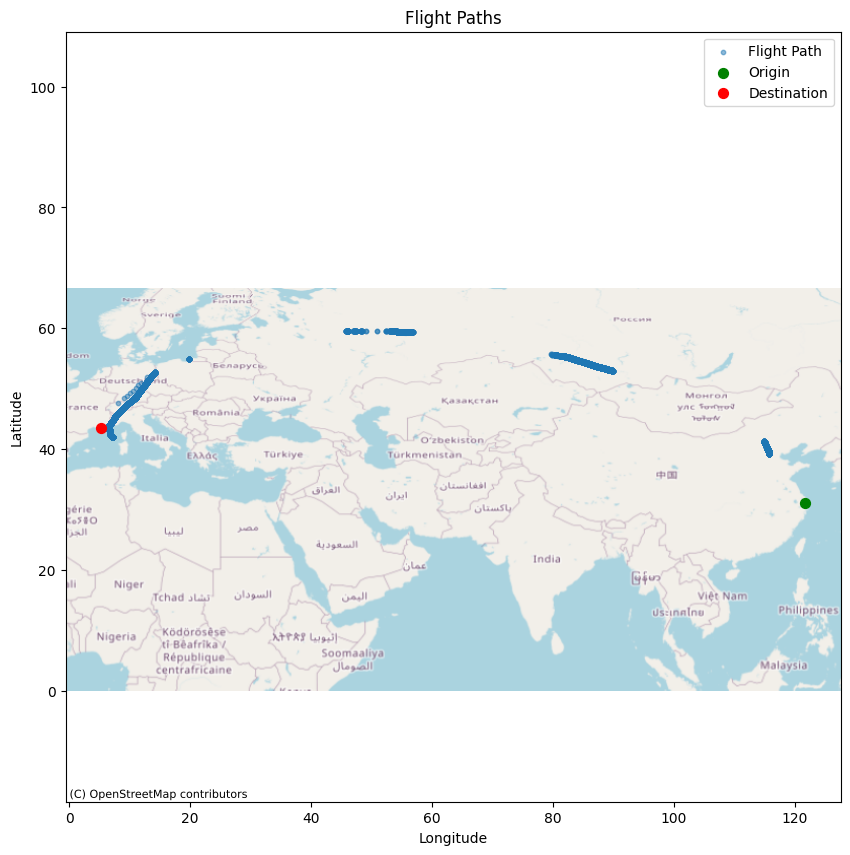

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


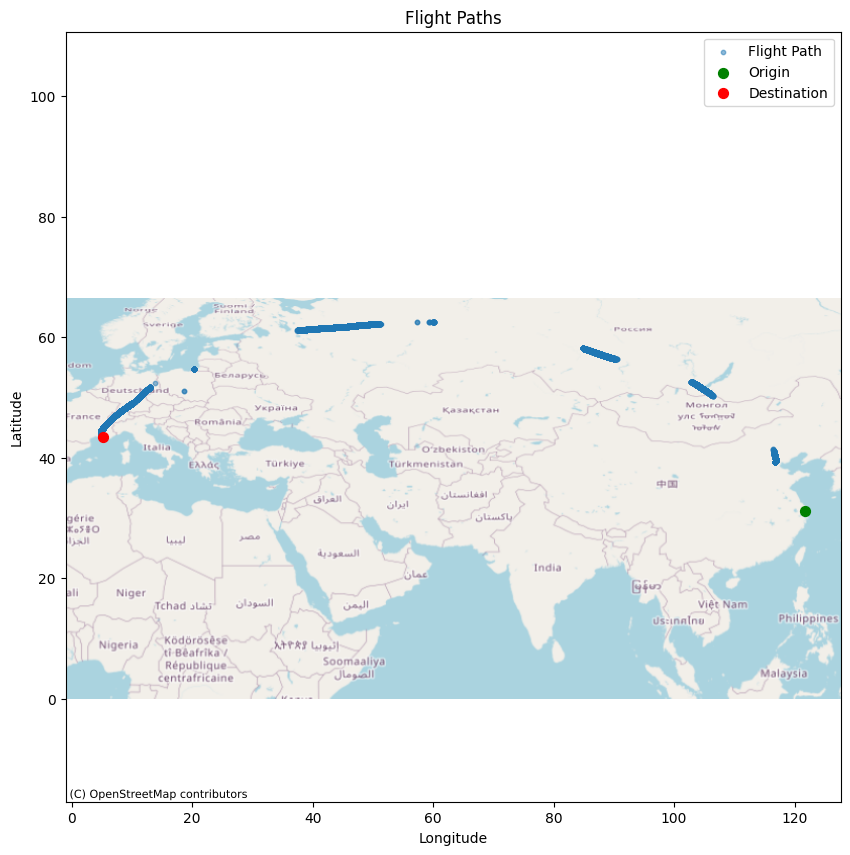

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


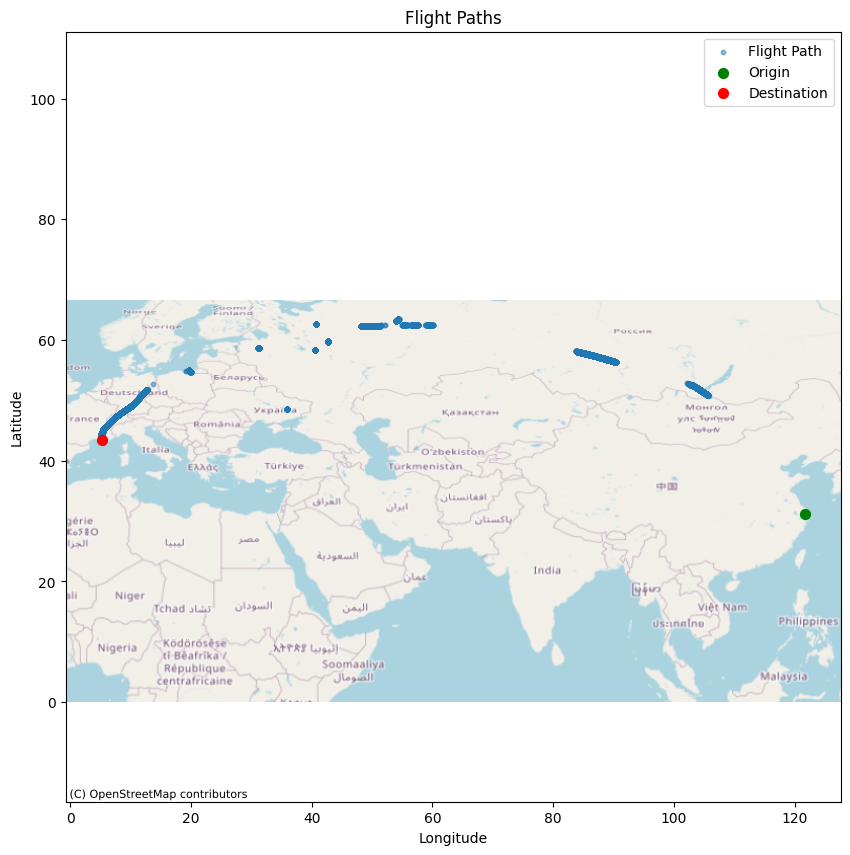

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


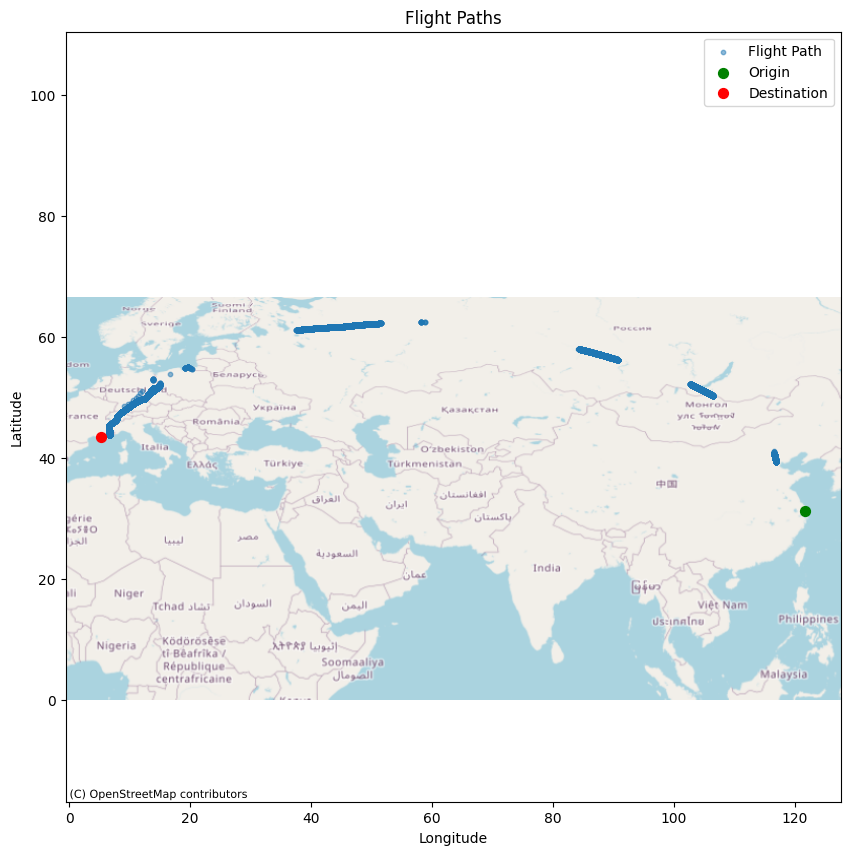

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


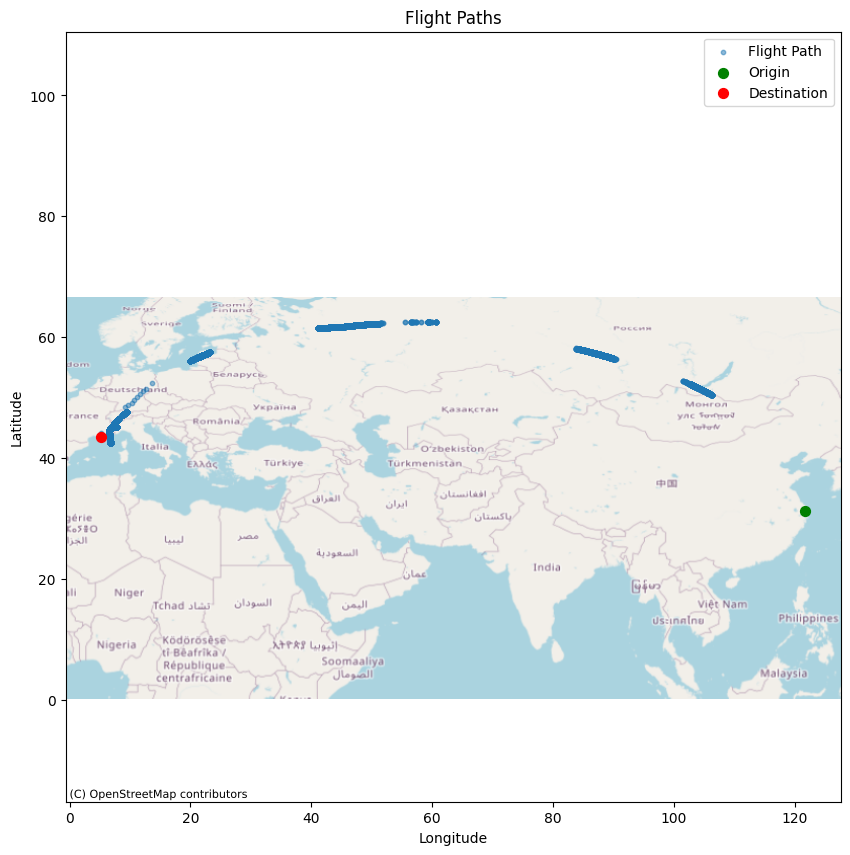

In [7]:
for flight_id in list_of_similar_flights:
    # gemini generated code
    import contextily as ctx
    import matplotlib.pyplot as plt

    df = load_parquet(f"{base_dir}/data/flights_train/{flight_id}.parquet")
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(df["longitude"], df["latitude"], alpha=0.5, s=10, label="Flight Path")
    ax.scatter(
        origin_info["longitude"],
        origin_info["latitude"],
        color="green",
        label="Origin",
        s=50,
        zorder=5,
    )
    ax.scatter(
        destination_info["longitude"],
        destination_info["latitude"],
        color="red",
        label="Destination",
        s=50,
        zorder=5,
    )

    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)

    ax.legend()
    ax.set_title("Flight Paths")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal", adjustable="datalim")

    plt.show()

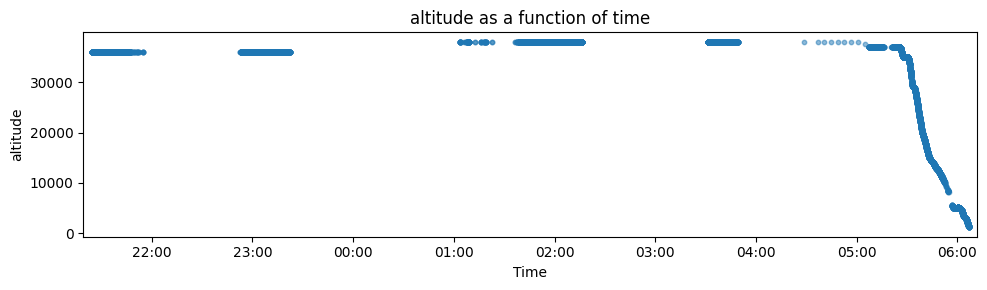

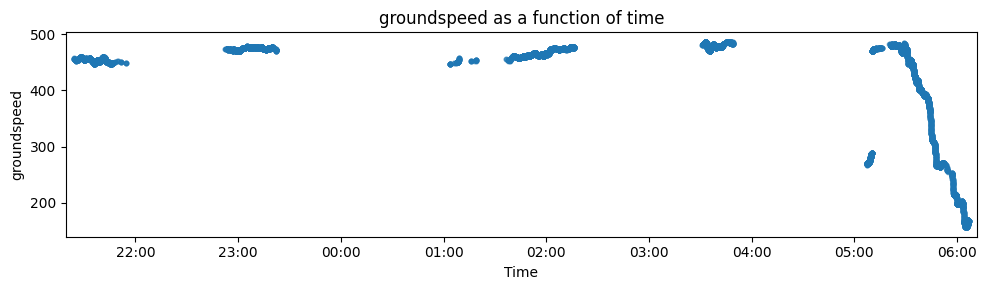

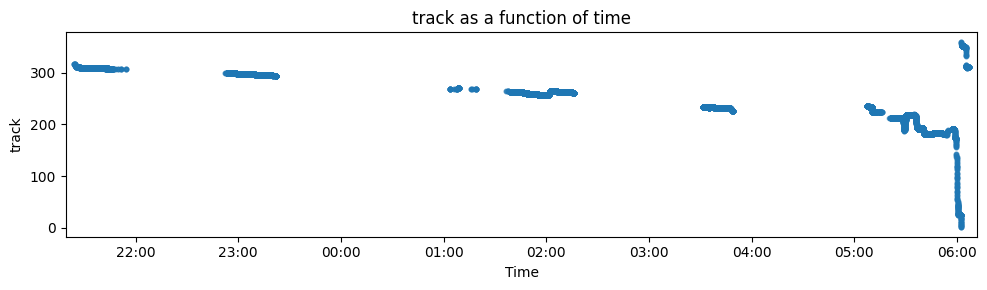

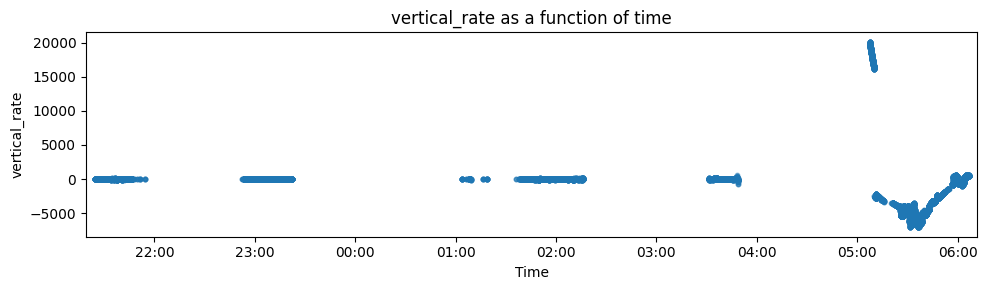

In [ ]:
# plot time series for numeric features (excluding timestamp itself)
if "timestamp" in df.columns:
    # ensure timestamp is datetime for better x-axis formatting
    try:
        df = df.copy()
        df["timestamp"] = pd.to_datetime(df["timestamp"])
    except Exception:
        pass

x = df["timestamp"]
xlabel = "Time"
for feature in ["altitude", "groundspeed", "track", "vertical_rate"]:
    plt.figure(figsize=(10, 3))
    plt.scatter(x, df[feature], alpha=0.5, s=10)
    plt.title(f"{feature} as a function of time")
    plt.xlabel(xlabel)
    plt.xlim(x.min() - pd.Timedelta(minutes=5), x.max() + pd.Timedelta(minutes=5))
    plt.ylabel(feature)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))
    plt.tight_layout()
    plt.show()

In [ ]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_file("parquet_data_profile.html")